In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import os

import scipy.sparse.linalg as spsl

import numpy as np


In [2]:
h1=5
w1=1
folderName = 'SteinFigures_CV_2D/h'+repr(h1)

folder = os.path.join(os.getcwd(),folderName)
if not os.path.exists(folder):
        os.makedirs(folder)

#alpha_coupling = 0.0
def force(x):
    f=np.zeros(2)
    f[0] = -h1*4*(x[0]**2-w1)*x[0] # - alpha_coupling*x[1];
    f[1] = -x[1]  #- alpha*x[0];
    return f

def energy(x):
    return h1*(x[0]**2-w1)**2 + 0.5*x[1]**2 #+ 0.5*alpha_coupling*x[0]*x[1]

def energy_DW(x):
    return h1*(x**2-w1)**2 

def energy_HO(x):
    return 0.5*x**2

def energy_trajectory(x):
    E =np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        E[i] =  h1*(x[i,0]**2-w1)**2 + 0.5*x[i,1]**2  #+ 0.5*alpha_coupling*x[i,0]*x[i,1]
    return E

kT=1

nrParticles = 1000


# Define simulation parameters for all methods

In [3]:
# take a gaussian as initial conditions.
x = np.random.randn(nrParticles, 2) * 0.1 + 1.0
dim=2

q_density = 1.0/np.sqrt(2*np.pi*0.1**2)**dim * np.exp(-sum(x-.2)**2 / (2*0.1**2))

X0=x
print(energy_trajectory(x).shape)

(1000,)


In [4]:
numberOfSteinSteps = 100 #50000

X_short = np.copy(X0)

epsilon_step=0.1



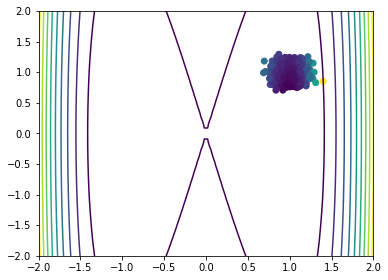

In [5]:
def plotSampling_fromData(x, methodName=None, color='b', title = 'Initial condition', savefigure=None):
    
   
    sc1=2
    sc2=3
    minX=sc1
    maxX=sc1
    minY=sc2
    maxY=sc2

    xe=np.linspace(-minX, maxX, 100)
    ye=np.linspace(-minY, minY, 100)
    
    energyContours=np.zeros((100, 100))
    for i in range(0,len(xe)):
        for j in range(0,len(ye)):
            xtmp=np.array([xe[i], ye[j]] )

            energyContours[j,i]=energy(xtmp)

    
    fig = plt.figure(figsize=(6,4.5))
    ax = fig.add_subplot(111)
    ax.scatter(x[:,0],x[:,1], c=energy_trajectory(x))
    ax.contour(xe, ye, energyContours, 10)
    ax.set_xlim([-2,2])
    ax.set_ylim([-2,2])
    if savefigure is not None:
        plt.savefig(savefigure,  format='png', dpi=100, bbox_inches='tight')
        
    plt.show()
        
   
    
plotSampling_fromData(x, methodName=None, color='b', title = 'Initial condition', savefigure=folderName+'/initial_distribution.png')

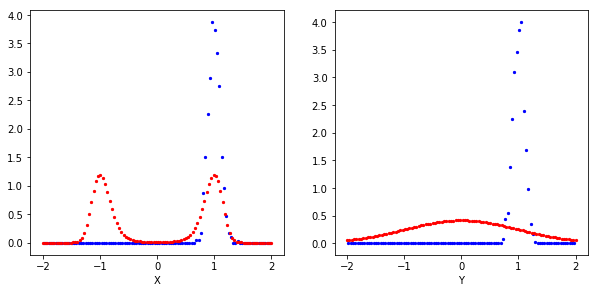

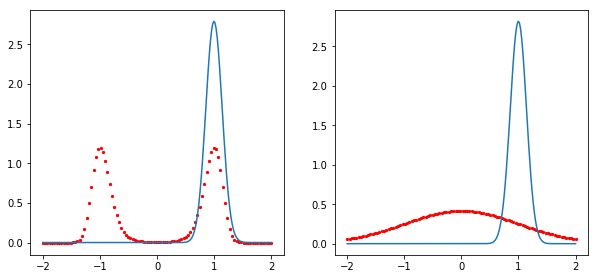

In [6]:
def plotDistributions(X0, figname = 'distr'):
    xx = np.linspace(-2,2,100)
    yy = np.linspace(-2,2,100)
    data, bins = np.histogram(X0[:,0], xx, density=True)

    bin_centers = 0.5*(bins[1:] + bins[:-1])

    fig = plt.figure(figsize=(10,4.5))
    ax = fig.add_subplot(121)

    Zx = sum(np.exp(-energy_DW(xx))) * (xx[1]-xx[0])
    ax.scatter(bin_centers, data , c='b', s=5)
    ax.scatter(xx, np.exp(- energy_DW(xx))/Zx , c='r', s=5)
    ax.set_xlabel('X')
    ax = fig.add_subplot(122)

    data, bins = np.histogram(X0[:,1], yy, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])

    Zy = sum(np.exp(-energy_HO(yy))) * (yy[1]-yy[0])
    ax.scatter(bin_centers, data , c='b', s=5)
    ax.scatter(yy, np.exp(- energy_HO(yy))/Zy , c='r', s=5)
    ax.set_xlabel('Y')
    plt.savefig(figname,  format='png', dpi=100, bbox_inches='tight')
    plt.show()
    
    from sklearn.neighbors.kde import KernelDensity
    kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(X0[:,0].reshape(-1,1))

    X_plot = np.linspace(-2, 2, 200)[:, np.newaxis]
    log_dens = kde.score_samples(X_plot)
    
    fig = plt.figure(figsize=(10,4.5))
    ax = fig.add_subplot(121)
    
    ax.plot(X_plot[:, 0], np.exp(log_dens), '-')
    ax.scatter(xx, np.exp(- energy_DW(xx))/Zx , c='r', s=5)
    
    kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(X0[:,1].reshape(-1,1))

    X_plot = np.linspace(-2, 2, 200)[:, np.newaxis]
    log_dens = kde.score_samples(X_plot)
    
    ax = fig.add_subplot(122)
    ax.plot(X_plot[:, 0], np.exp(log_dens), '-')
    
    ax.scatter(yy, np.exp(- energy_HO(yy))/Zy , c='r', s=5)
    plt.show()
    


plotDistributions(X0, figname = 'initial_distribution')


# Define Langevin step

In [7]:

def Langevin_step(x, p, dt):
    
    gamma = 1
    kT = 1
    a = np.exp(-gamma * (dt))
    b = np.sqrt(1 - np.exp(-2 * gamma * (dt)))
    
    for n in range(len(x)):
        
        xn=x[n,:]
        pn=p[n,:]
        
        f = force(xn)
      
        pn = pn + 0.5* f * dt
        xn = xn + 0.5* pn * dt
        pn = (a * pn) + b * np.random.randn(*xn.shape) * np.sqrt(kT)
        f = force(xn)
        xn = xn + 0.5* pn * dt
        pn = pn + 0.5* f * dt
        
        x[n,:]=xn
        p[n,:]=pn
        
    return x, p


def Langevin_serial_step(x, p, dt):
    
    gamma = 1
    kT = 1
    a = np.exp(-gamma * (dt))
    b = np.sqrt(1 - np.exp(-2 * gamma * (dt)))
    
        
    xn=x
    pn=p
        
    f = force(xn)
      
    pn = pn + 0.5* f * dt
    xn = xn + 0.5* pn * dt
    pn = (a * pn) + b * np.random.randn(*xn.shape) * np.sqrt(kT)
    f = force(xn)
    xn = xn + 0.5* pn * dt
    pn = pn + 0.5* f * dt
        
    x=xn
    p=pn
        
    return x, p

def HMC_step(x, p, dt):
    
    p = np.random.randn(*x.shape)
    
    for n in range(len(x)):
        
        xn=x[n,:]
        pn=p[n,:]
        
        Eold = energy(xn) + 0.5*pn**2
        
        f = force(xn)
      
        pn = pn + 0.5* f * dt
        xn = xn +  pn * dt

        f = force(xn)
        
        pn = pn + 0.5* f * dt
        
        Enew = energy(xn) + 0.5*pn**2
        
        acceptanceProba =  np.min([1, np.exp(-(Enew+ Eold)/kT)]);
    
        if ( acceptanceProba < np.random.rand(1)):
        
           pass
        
        else:
            x[n,:]=xn
            p[n,:]=pn
        
    return x, p




#  Define Stein force

In [8]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist

def compute_force(XL, leader_set):
       
    f = []
    
    for n in range(len(leader_set)):
        f.append( force(XL[leader_set[n]]))

    return f

def compute_force_all(XL):
       
    f = []
    
    for n in range(len(XL)):
        f.append( force(XL[n]))

    return f

def metric_cv(X, Y):

    return np.abs(X[np.newaxis,0] -Y[np.newaxis,0])

kernel_metric = 'euclidean'#metric_cv #

def compute_stein_force(XL, leader_set,  bandwidth=0.1, kernel_metric = 'euclidean',
                        collective_variable = None, gradient_collective_variable = None, 
                        return_kernel = False):
   
    my_force = compute_force(XL, leader_set)
    # create numpy array from the list force which has also units    
    force_resh = np.asarray(my_force)
    
    #print(force_resh.shape)
    #force_resh = force_resh.reshape(force_resh.shape[0], force_resh.shape[1]*force_resh.shape[2])
    
    # create numpy array from the list XL which has also units
    
    ############# CV #########################
    if collective_variable is not None:
        # apply theta(X)
        XL = collective_variable(XL)
        dXL = gradient_collective_variable(XL)
    ####################################
    
    # choose leader particles using the index set leader_set
    X_leader = XL[leader_set,:]
    
    # kernel scaling parameter
    h=bandwidth
    
    
    
    
#     if kernel_metric == 'projX':
#         X1 = X_leader[:,0:1]
#         X1 =     np.array(X1, np.newaxis)
#         X2 = XL[:,0:1]
#         X2 =     np.array(X2, np.newaxis)
       
#         distances = cdist(X1, X2, metric = 'euclidean')
#     else:
    # this is theta(X) already
    distances = cdist(X_leader, XL, metric = 'euclidean')
    kernel = np.exp(-distances**2 / h)
    
#     print('Kernel '+repr(kernel.shape))
#     print('XL '+repr(XL.shape))
#     print('dXL '+repr(dXL.shape))
                    
    f_MDforce = np.dot(kernel.transpose(), force_resh)
    f_MDforce = f_MDforce / len(leader_set)
    
    #     derivative part
    if collective_variable is not None:
        kernel_theta_1 = kernel * X_leader
        kernel_theta_2 = (XL*kernel.transpose()).transpose()
        kernel_theta = kernel_theta_1 - kernel_theta_2

        f_der = -2.0/h * np.dot(kernel_theta.transpose(), dXL)
        

    
        
    else:
        
        f_der = -2.0/h * np.dot(kernel.transpose(), X_leader)
        f_der += 2.0/h * np.outer(np.sum(kernel,0),np.ones(XL.shape[1])) * XL
        
    f_der = f_der / len(leader_set)
    
    stein_force = f_MDforce + f_der
    
    if return_kernel:
        return stein_force, kernel
    else:
    #if return_kernel is None:
        return stein_force#, grad_force
    #else:
    #    return f_MDforce + f_der, grad_force, kernel



# Iterate Stein (only Stein, no Langevin)

(1000, 2)


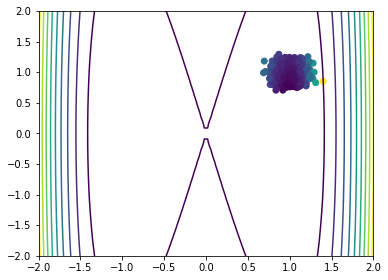

Stein iteration 0


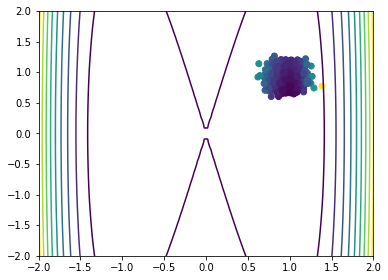

Stein iteration 5


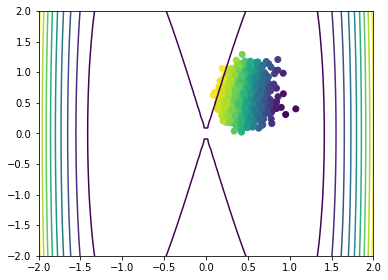

Stein iteration 10


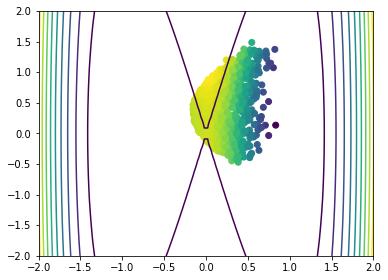

Stein iteration 15


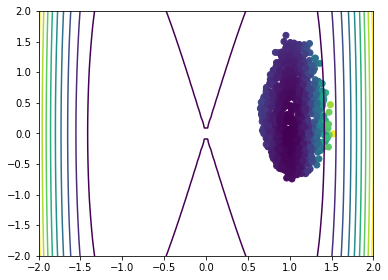

Stein iteration 20


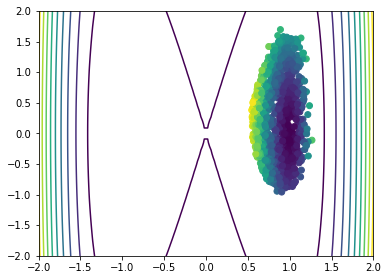

Stein iteration 25


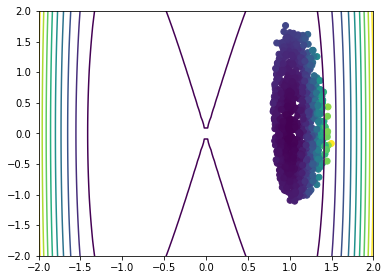

Stein iteration 30


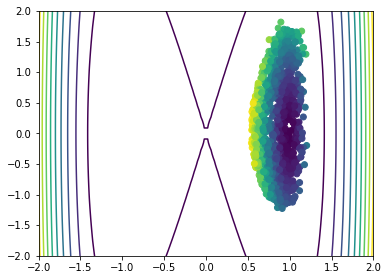

Stein iteration 35


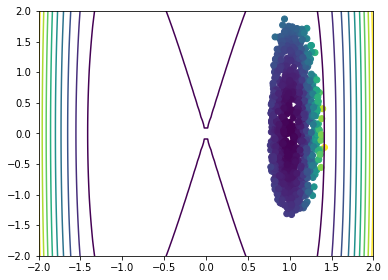

Stein iteration 40


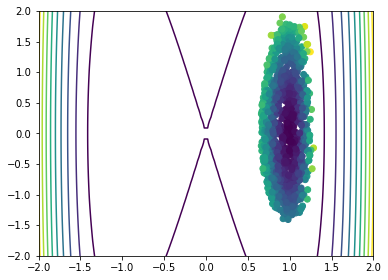

Stein iteration 45


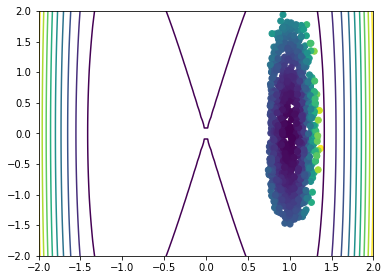

Stein iteration 50


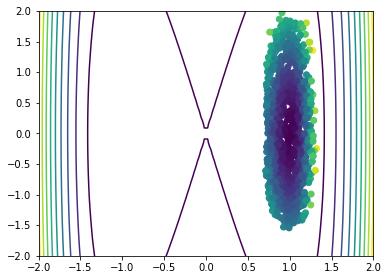

Stein iteration 55


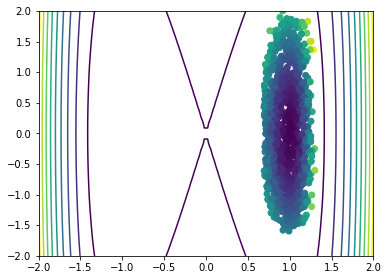

Stein iteration 60


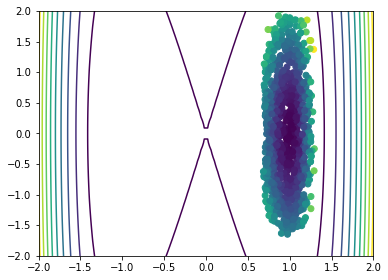

Stein iteration 65


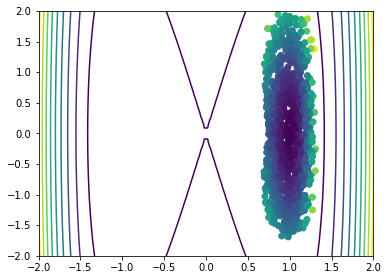

Stein iteration 70


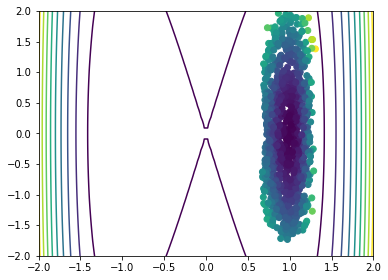

Stein iteration 75


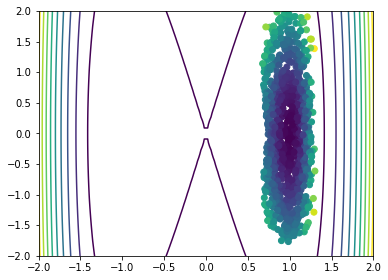

Stein iteration 80


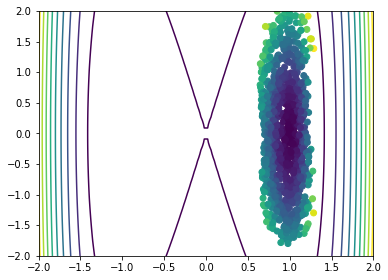

Stein iteration 85


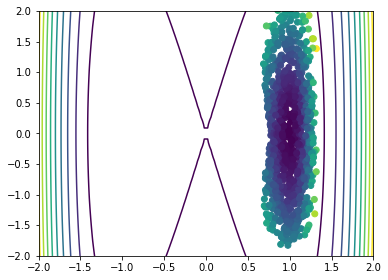

Stein iteration 90


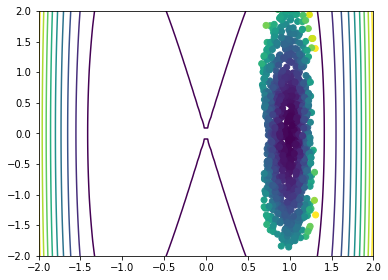

Stein iteration 95


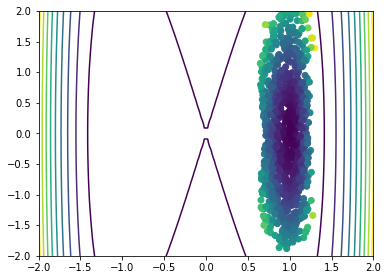

In [9]:
np.random.seed(seed=1)

# choose leader set
numberOfLeaderParticles = int(1.0*(X_short.shape[0]))
leader_set = range(X_short.shape[0])
#np.random.choice(range(X_short.shape[0]), numberOfLeaderParticles)#np.array(range(X_short.shape[0]))# 

mass = 1 

q = X_short

BDW = 1.0

XL=np.copy(q)
print(q.shape)
plotSampling_fromData(q, methodName=None, color='b', title = 'Initial condition')
f = compute_stein_force(XL,leader_set, bandwidth=BDW)

modit = int(numberOfSteinSteps/20)
moditfig = int(numberOfSteinSteps/20)
KL = np.zeros(numberOfSteinSteps)
Obs_average = np.zeros(numberOfSteinSteps)

states_evolution_stein =[]
stein_force_save=[];

gti=np.zeros(q.shape[0])
fudge_factor = 1e-3

for ns in range(numberOfSteinSteps):
    if ns%modit==0:
        print('Stein iteration '+repr(ns))
    leader_set=np.random.choice(range(X_short.shape[0]), numberOfLeaderParticles)
    f= compute_stein_force(XL,leader_set,bandwidth=BDW)
    
    dt_stein = epsilon_step +np.random.randn(1)*0.01
    XL = XL + dt_stein * f # / (0.001*ns+1)
    
    
#     ### adagrad 
#     gti+=f**2
#     adjusted_grad = f / (fudge_factor + np.sqrt(gti))
#     XL = XL + epsilon_step*adjusted_grad
        
    
    stein_force_save.append(f)
    q =  np.copy(XL)
    #q_density = q_density / abs(1.0 + epsilon_step*grad_force)
    
    #weights = np.exp(-energy(q)) / q_density
    #KL[ns] = np.mean(np.log(weights))
    #Obs_average[ns] = np.sum(weights*q) / np.sum(weights)
    Obs_average[ns] = np.mean(q)
    
    states_evolution_stein.append(q)
    
    ## plot progress
    if ns%moditfig==0:
        plotSampling_fromData(q, methodName=None, color='b', title = 'Initial condition', savefigure=None)
    if np.isnan(q).any():
        print('Explosion. Nan.')
        break
    

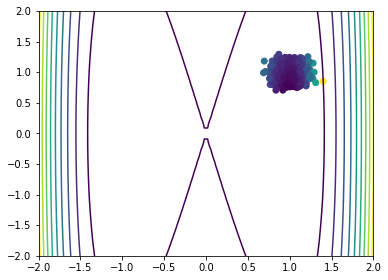

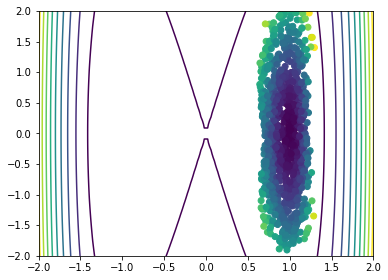

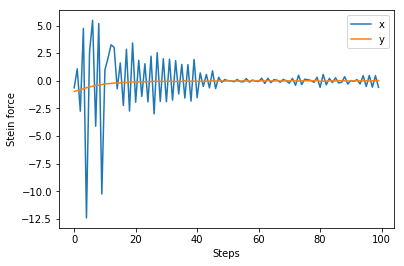

In [10]:
plotSampling_fromData(X0,  methodName=None, color='b', title='Initial state')
plotSampling_fromData(q, methodName=None, color='b', title = 'After '+repr(numberOfSteinSteps)+' Stein steps',
                     savefigure = folderName+'/stein.png')

fs = np.asarray(stein_force_save)

plt.plot(range(len(fs)), np.mean(fs, axis=1))
plt.xlabel('Steps')
plt.ylabel('Stein force')
plt.legend(['x','y'])
plt.show()

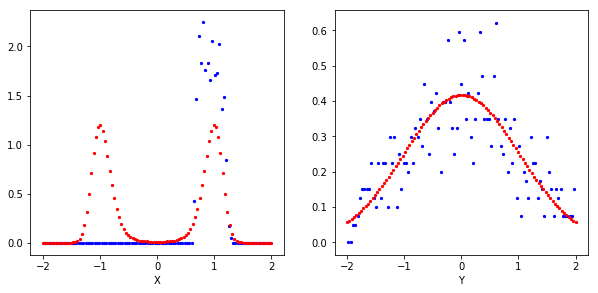

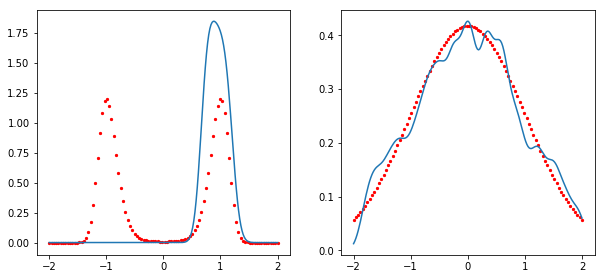

In [11]:
plotDistributions(q, figname =  folderName+'/stein_distr.png')

# Stein CV projection

In [12]:
def projection_x(x):
    return x[:,0:1]

dimension =2
def gradient_projection_x(x):
    g = np.zeros((x.shape[0],dimension))
    g[:,0:1] = 1
    return g

def identity(x):
    return x

def gradient_identity(x):
    return np.eye(x.shape[0], x.shape[1])

(1000, 2)


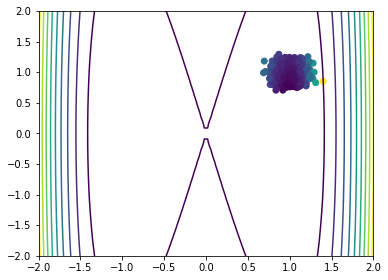

Stein iteration 0


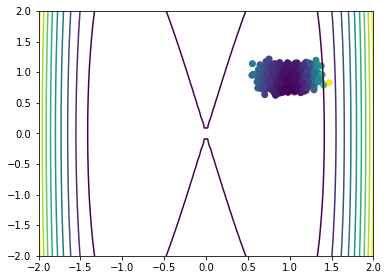

Stein iteration 5


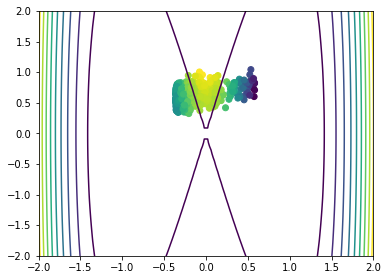

Stein iteration 10


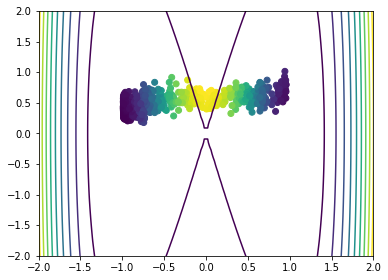

Stein iteration 15


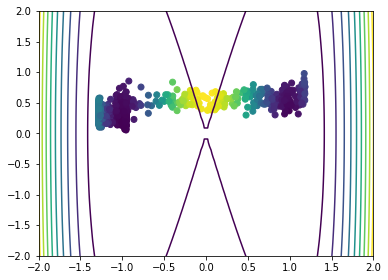

Stein iteration 20


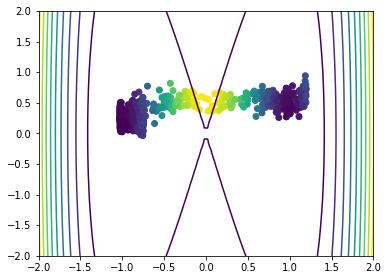

Stein iteration 25


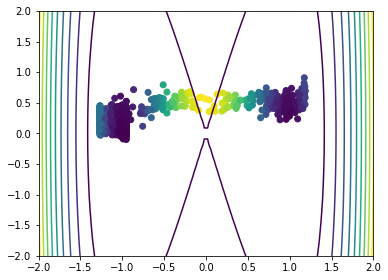

Stein iteration 30


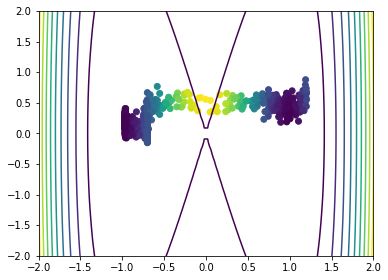

Stein iteration 35


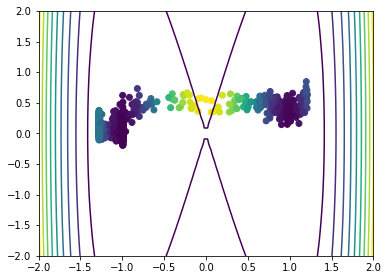

Stein iteration 40


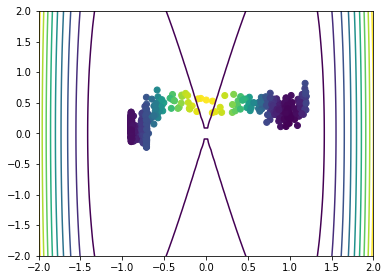

Stein iteration 45


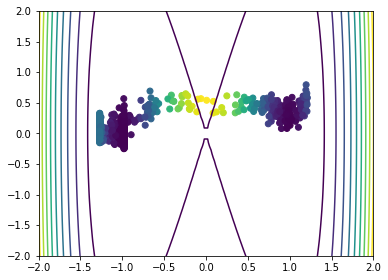

Stein iteration 50


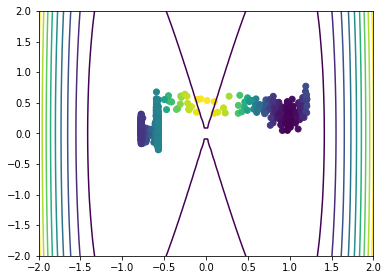

Stein iteration 55


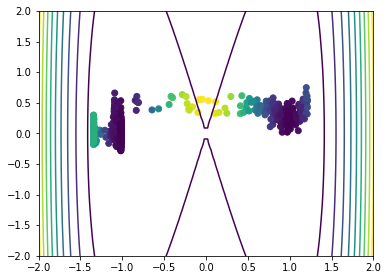

Stein iteration 60


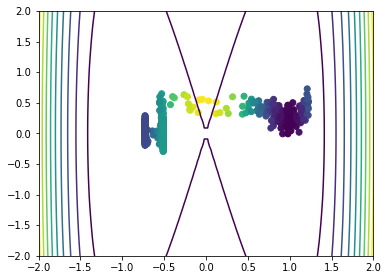

Stein iteration 65


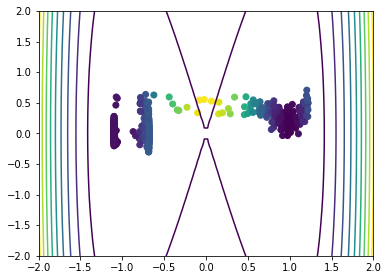

Stein iteration 70


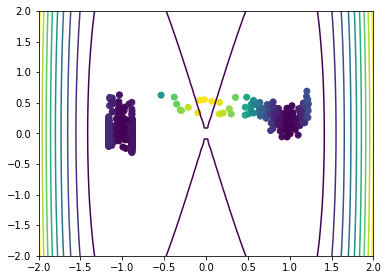

Stein iteration 75


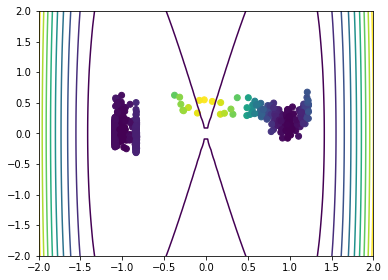

Stein iteration 80


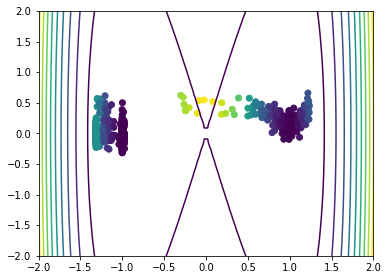

Stein iteration 85


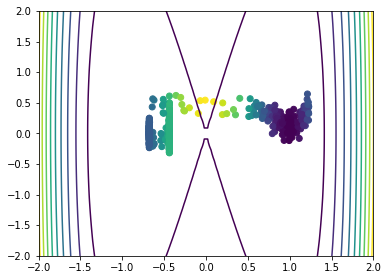

Stein iteration 90


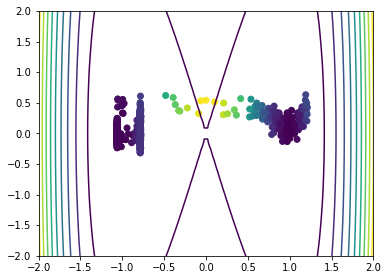

Stein iteration 95


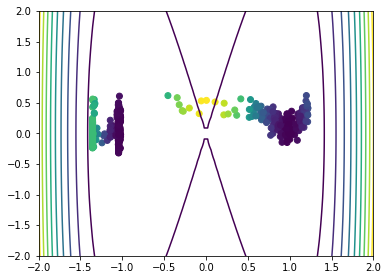

In [13]:
collective_variable = projection_x
gradient_collective_variable = gradient_projection_x


#numberOfSteinSteps = 1000

# choose leader set
numberOfLeaderParticles = int(1.0*(X_short.shape[0]))
leader_set = range(X_short.shape[0])
#np.random.choice(range(X_short.shape[0]), numberOfLeaderParticles)#np.array(range(X_short.shape[0]))# 

mass = 1 

q = X_short

BDW = 0.1

XL=np.copy(q)
print(q.shape)
plotSampling_fromData(q, methodName=None, color='b', title = 'Initial condition')
f = compute_stein_force(XL,leader_set, bandwidth=BDW, collective_variable = collective_variable, gradient_collective_variable = gradient_collective_variable)#,kernel_metric = 'projX')


modit = int(numberOfSteinSteps/20)
moditfig = int(numberOfSteinSteps/20)
KL = np.zeros(numberOfSteinSteps)
Obs_average = np.zeros(numberOfSteinSteps)

states_CV_evolution_stein =[]
stein_force_save=[];

gti=np.zeros(q.shape[0])
fudge_factor = 1e-3

epsilon_step_cv_stein = 0.1

for ns in range(numberOfSteinSteps):
    if ns%modit==0:
        print('Stein iteration '+repr(ns))
    leader_set=np.random.choice(range(X_short.shape[0]), numberOfLeaderParticles)
    f = compute_stein_force(XL,leader_set, bandwidth=BDW, collective_variable = collective_variable, gradient_collective_variable = gradient_collective_variable)#,kernel_metric = 'projX')
    #print(f.shape)
    dt_stein = epsilon_step_cv_stein +np.random.randn(1)*0.01
    XL = XL + dt_stein * f  #/ (0.001*ns+1)
    
    
#     ### adagrad 
#     gti+=f**2
#     adjusted_grad = f / (fudge_factor + np.sqrt(gti))
#     XL = XL + epsilon_step*adjusted_grad
        
    
    stein_force_save.append(f)
    q =  np.copy(XL)
    Obs_average[ns] = np.mean(q)
    
    states_CV_evolution_stein.append(q)
    
    ## plot progress
    if ns%moditfig==0:
        plotSampling_fromData(q, methodName=None, color='b', savefigure=None)
    if np.isnan(q).any():
        print('Explosion. Nan.')
        break
    

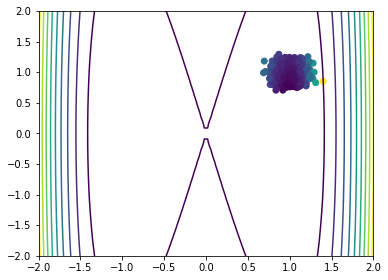

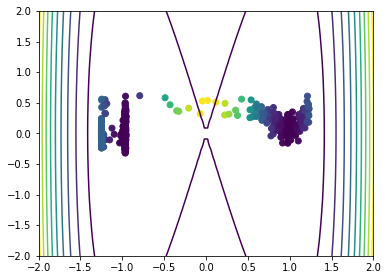

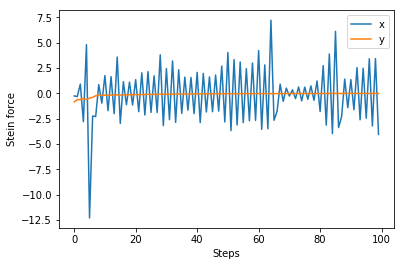

In [14]:
plotSampling_fromData(X0,  methodName=None, color='b', title='Initial state')
plotSampling_fromData(q, methodName=None, color='b', title = 'After '+repr(numberOfSteinSteps)+' Stein steps',
                     savefigure = folderName+'/stein_cv.png')

fs = np.asarray(stein_force_save)

plt.plot(range(len(fs)), np.mean(fs, axis=1))
plt.xlabel('Steps')
plt.ylabel('Stein force')
plt.legend(['x','y'])
plt.show()

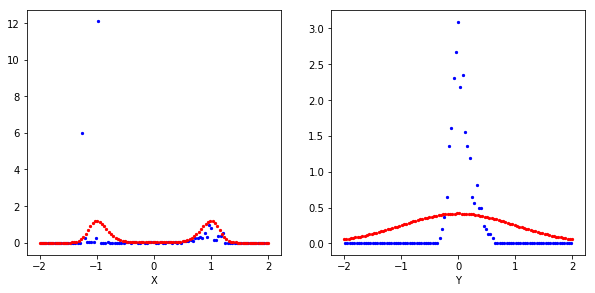

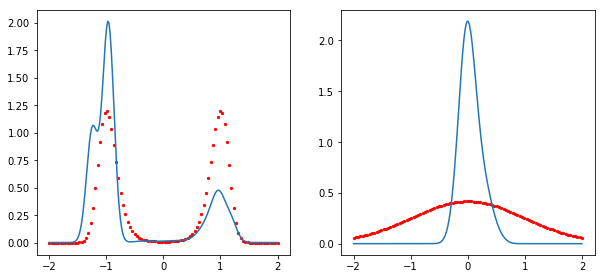

In [15]:
plotDistributions(q, figname =    folderName+'/stein_cv_distr.png')

# Parallel Langevin steps

(1000, 2)


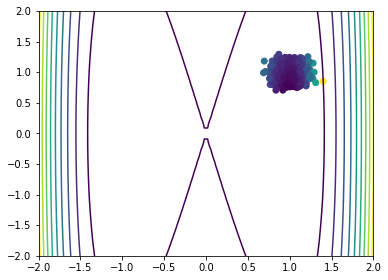

Langevin iteration 0


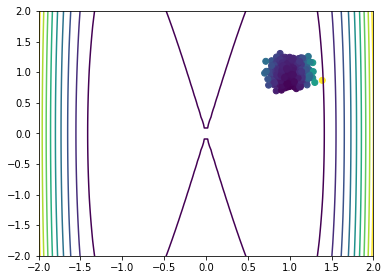

Langevin iteration 5


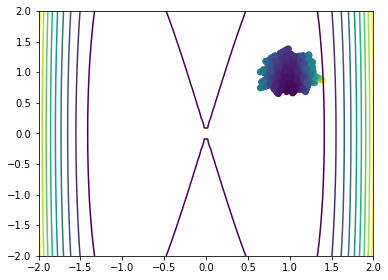

Langevin iteration 10


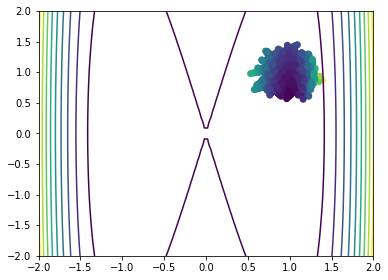

Langevin iteration 15


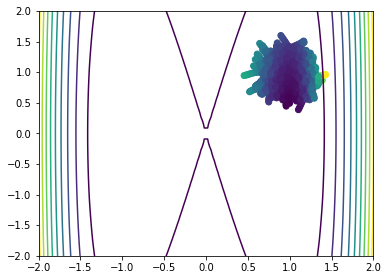

Langevin iteration 20


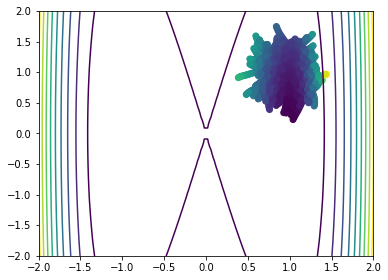

Langevin iteration 25


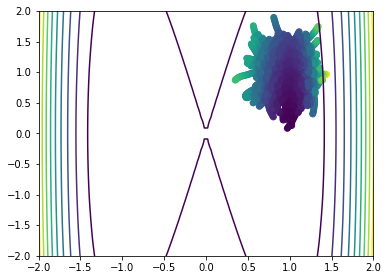

Langevin iteration 30


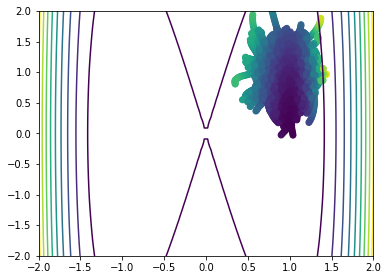

Langevin iteration 35


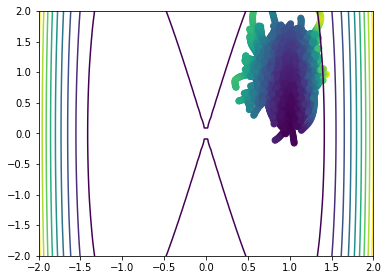

Langevin iteration 40


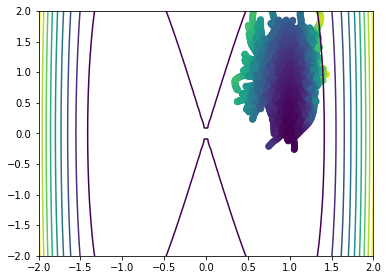

Langevin iteration 45


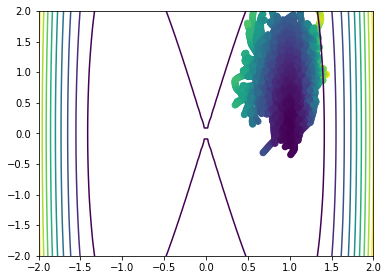

Langevin iteration 50


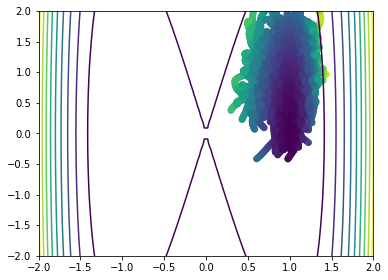

Langevin iteration 55


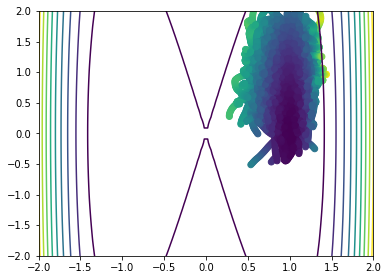

Langevin iteration 60


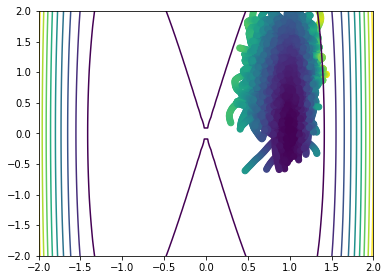

Langevin iteration 65


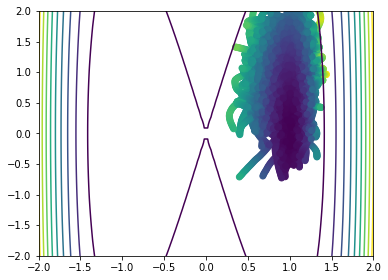

Langevin iteration 70


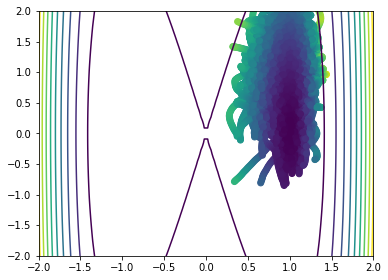

Langevin iteration 75


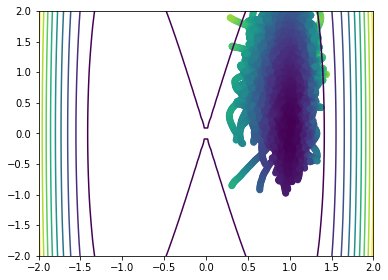

Langevin iteration 80


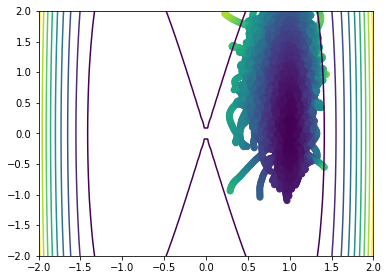

Langevin iteration 85


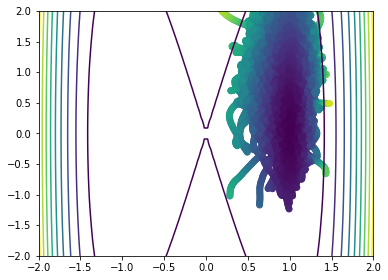

Langevin iteration 90


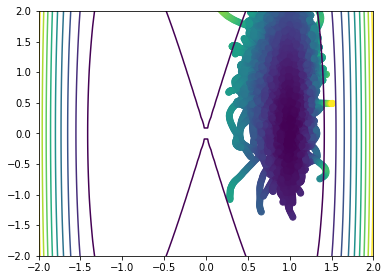

Langevin iteration 95


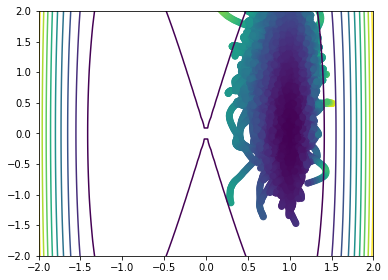

In [16]:
numberOfSerialLangevinSteps =numberOfSteinSteps 
#modit=100000
#moditfig=100000

dt=0.01

gamma = 1
kT = 1
a = np.exp(-gamma * (dt))
b = np.sqrt(1 - np.exp(-2 * gamma * (dt)))

X_short = np.copy(X0)
p = np.random.randn(*X_short.shape)


mass = 1 


q = X_short
print(q.shape)

XL=np.copy(q)
plotSampling_fromData(q, methodName=None, color='b', title = 'Initial condition')
#f = compute_force_all(XL)

Obs_average = np.zeros(numberOfSteinSteps)

states_evolution_Langevin=[]
#states_evolution_Langevin_serial=[]

for ns in range(numberOfSerialLangevinSteps):
    if ns%modit==0:
        print('Langevin iteration '+repr(ns))

    q, p = Langevin_step(q, p, dt) #(XL + epsilon_step * f)#/mass );
    states_evolution_Langevin.append(np.copy(q))
    #Obs_average[ns] = np.mean(q)
    
    ## plot progress
    if ns%moditfig==0:
        all_data =np.asarray(states_evolution_Langevin)
        all_data = all_data.reshape(all_data.shape[0]*all_data.shape[1],all_data.shape[2])
        #print(all_data.shape)
        plotSampling_fromData(all_data, methodName=None, color='b', title = 'Initial condition', savefigure=None)
    if np.isnan(q).any():
        print('Explosion. Nan.')
        break
    

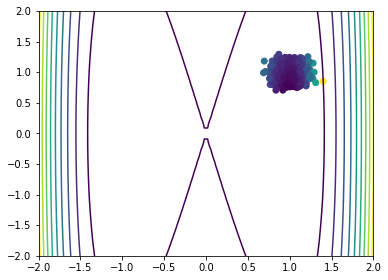

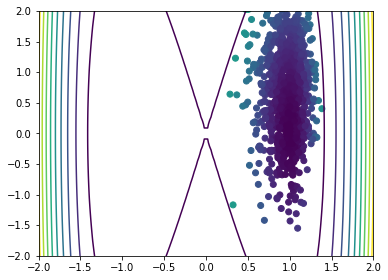

In [17]:
plotSampling_fromData(X0,  methodName=None, color='b', title='Initial state')
plotSampling_fromData(q, methodName=None, color='b', title = 'After '+repr(numberOfSteinSteps)+' Parallel langevin steps',
                     savefigure = folderName+'/parallel_langevin.png')


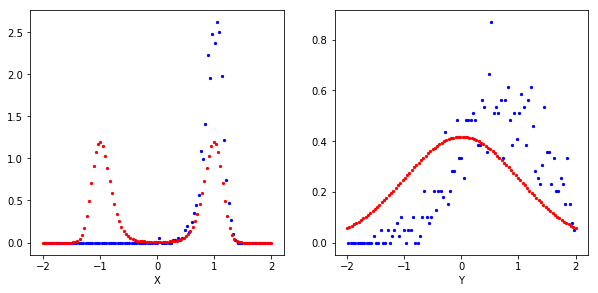

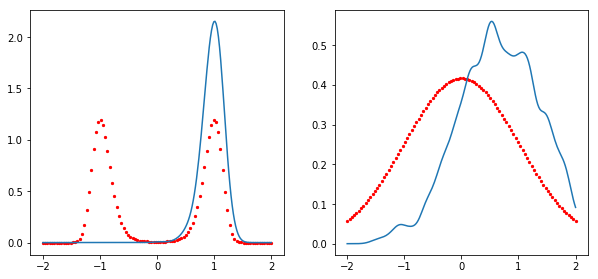

In [18]:
plotDistributions(q, figname = folderName+'/langevin_parallel_distr.png')

# Serial Langevin steps

Number of serial langevin steps 100
(2,)


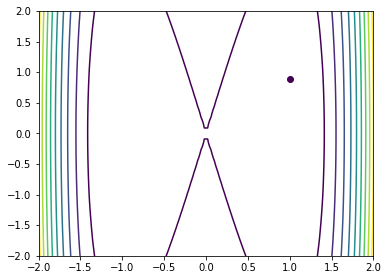

Langevin iteration 0


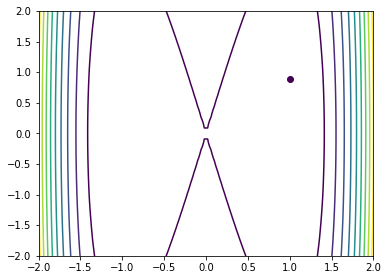

Langevin iteration 10
Langevin iteration 20
Langevin iteration 30
Langevin iteration 40
Langevin iteration 50


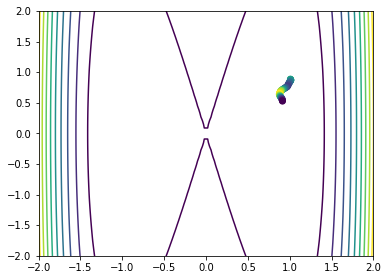

Langevin iteration 60
Langevin iteration 70
Langevin iteration 80
Langevin iteration 90


In [19]:
numberOfSerialLangevinSteps =numberOfSteinSteps #* X0.shape[0]
print('Number of serial langevin steps '+repr(numberOfSerialLangevinSteps))
modit=int(numberOfSerialLangevinSteps/10)
moditfig=int(numberOfSerialLangevinSteps/2)

dt=0.01

gamma = 1
kT = 1
a = np.exp(-gamma * (dt))
b = np.sqrt(1 - np.exp(-2 * gamma * (dt)))

X_short = np.copy(X0[0])
p = np.random.randn(*X_short.shape)


mass = 1 


q = X_short
print(q.shape)

XL=np.copy(q)
plotSampling_fromData(q[np.newaxis,:], methodName=None, color='b', title = 'Initial condition')
#f = compute_force_all(XL)

Obs_average = np.zeros(numberOfSteinSteps)

states_evolution_serialLangevin=[]
qserial = q

for ns in range(numberOfSerialLangevinSteps):
    if ns%modit==0:
        print('Langevin iteration '+repr(ns))

    q, p = Langevin_serial_step(q, p, dt) 
    #qserial = np.append(qserial, np.copy(q))
    states_evolution_serialLangevin.append( np.copy(q))
    #Obs_average[ns] = np.mean(q)
    
    ## plot progress
    if ns%moditfig==0:
        all_data = np.asarray(states_evolution_serialLangevin)
        #all_data = all_data.reshape(all_data.shape[0]*all_data.shape[1],all_data.shape[2])
        plotSampling_fromData(all_data, methodName=None, color='b', title = 'Initial condition', savefigure=None)
    if np.isnan(q).any():
        print('Explosion. Nan.')
        break
    

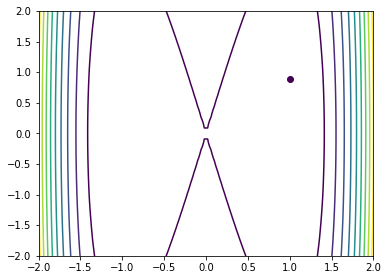

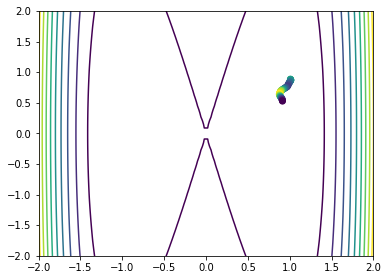

In [20]:
plotSampling_fromData(all_data[0:1],  methodName=None, color='b', title='Initial state')
plotSampling_fromData(all_data, methodName=None, color='b', title = 'After '+repr(numberOfSteinSteps)+' Langevin steps',
                     savefigure = folderName+'/serial_Langevin.png')


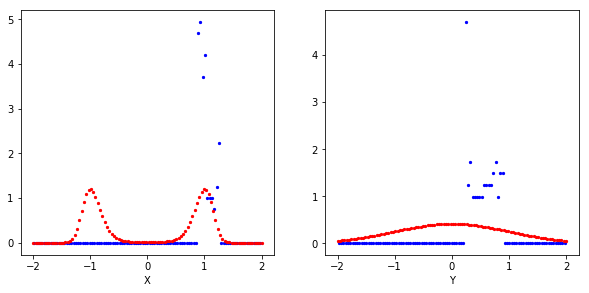

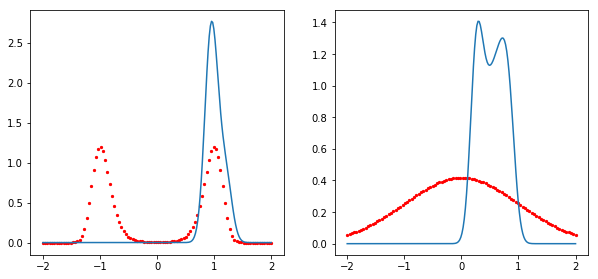

In [21]:
#print(np.asarray(states_evolution_serialLangevin).shape)
plotDistributions(np.asarray(states_evolution_serialLangevin), figname = folderName+'/langevin_serial_distr.png')

# Stein Langevin

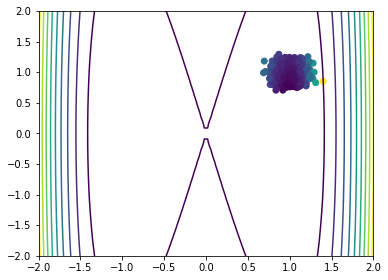

Stein iteration 0


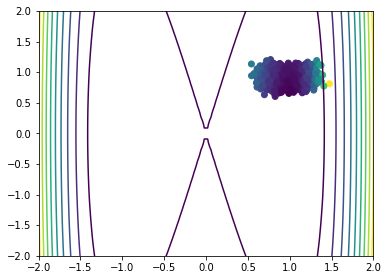

Stein iteration 5


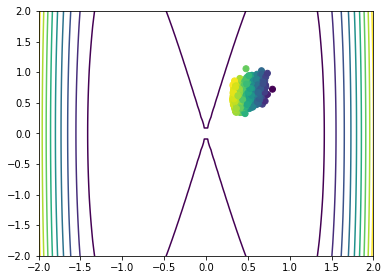

Stein iteration 10


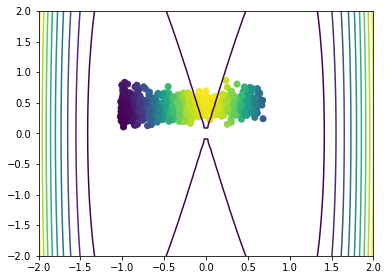

Stein iteration 15


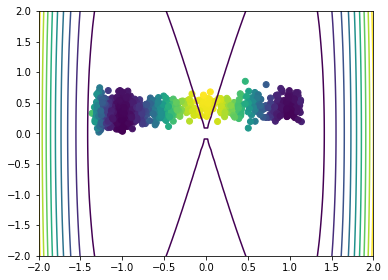

Stein iteration 20


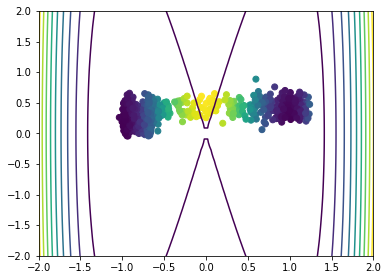

Stein iteration 25


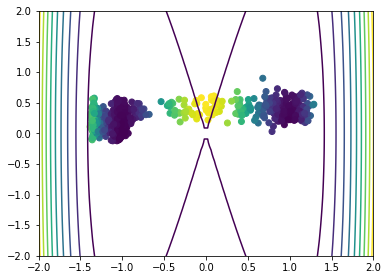

Stein iteration 30


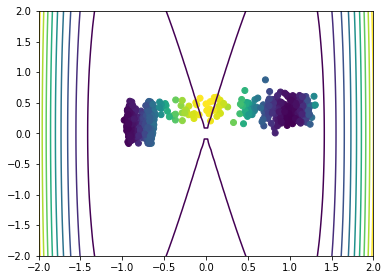

Stein iteration 35


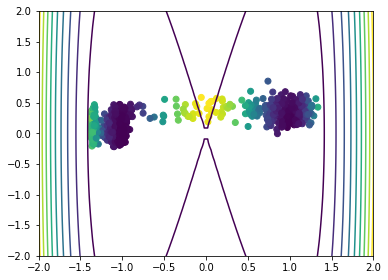

Stein iteration 40


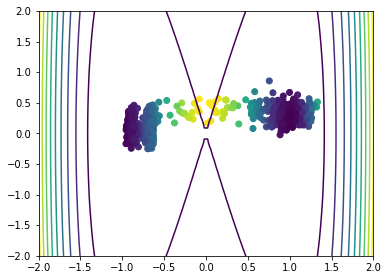

Stein iteration 45


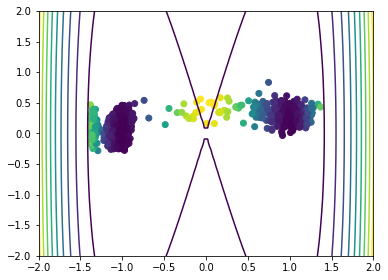

Stein iteration 50


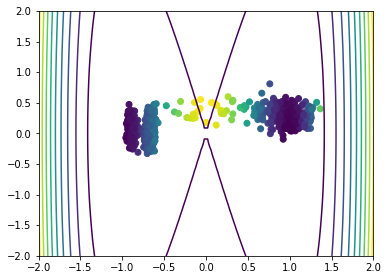

Stein iteration 55


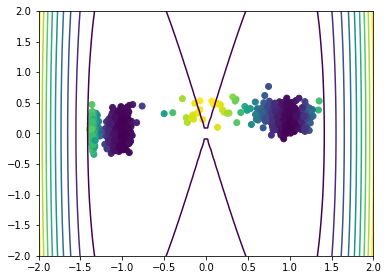

Stein iteration 60


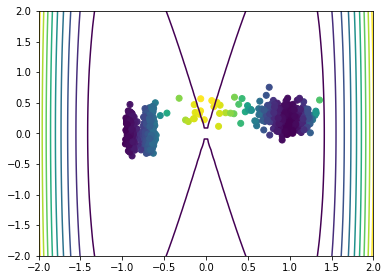

Stein iteration 65


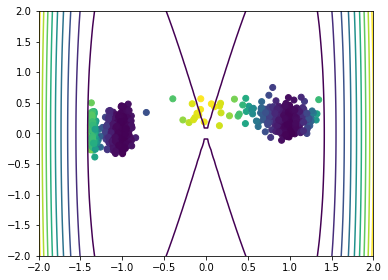

Stein iteration 70


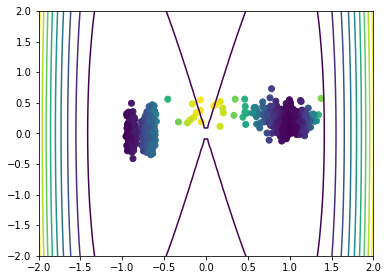

Stein iteration 75


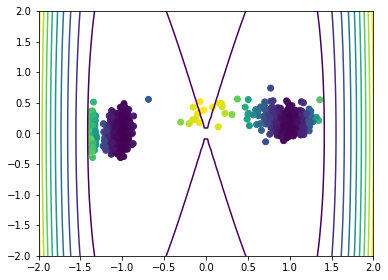

Stein iteration 80


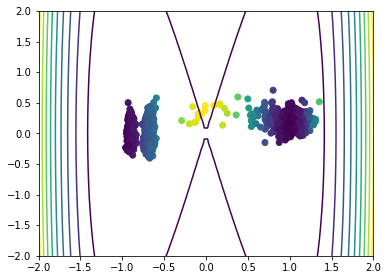

Stein iteration 85


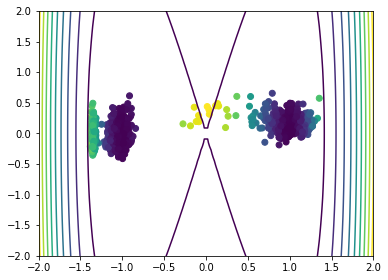

Stein iteration 90


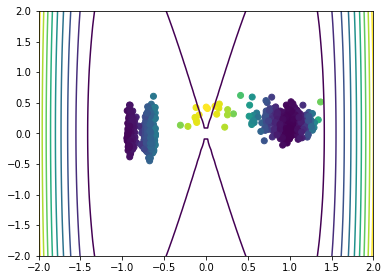

Stein iteration 95


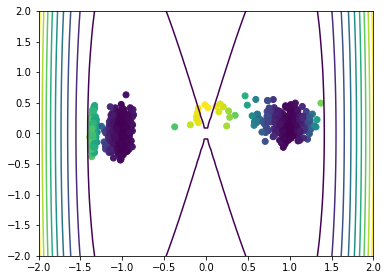

In [22]:
#numberOfSteinSteps = 1000#50000

X_short = np.copy(X0)

#epsilon_step=0.1

# choose leader set
numberOfLeaderParticles = int(1*(X_short.shape[0]))
leader_set = np.random.choice(range(X_short.shape[0]), numberOfLeaderParticles)#np.array(range(X_short.shape[0]))# 

mass = 1 

q = X_short

XL=np.copy(q)
plotSampling_fromData(q, methodName=None, color='b', title = 'Initial condition')
f = compute_stein_force(XL,leader_set, bandwidth=BDW, collective_variable = projection_x, gradient_collective_variable = gradient_projection_x)#,kernel_metric = 'projX')


#f = compute_force(XL)

modit = int(numberOfSteinSteps/20)
moditfig = int(numberOfSteinSteps/20)
KL = np.zeros(numberOfSteinSteps)
Obs_average = np.zeros(numberOfSteinSteps)

states_evolution_stein_langevin =[]

dt_langevin_step=0.01
numberOfLangevinSteps=1

for ns in range(numberOfSteinSteps):
    if ns%modit==0:
        print('Stein iteration '+repr(ns))
    f = compute_stein_force(XL,leader_set, bandwidth=BDW, collective_variable = projection_x, gradient_collective_variable = gradient_projection_x)#,kernel_metric = 'projX')


    XL = (XL + epsilon_step * f)
   # XL = XL + dt_stein * f / (0.001*ns+1)
    
    if numberOfLangevinSteps>0:
        p = np.random.randn(*XL.shape)
        for nl in range(numberOfLangevinSteps):
            XL, p = Langevin_step(XL, p, dt_langevin_step)
            #XL, p = HMC_step(XL, p, dt_langevin_step)

    q =  np.copy(XL)
    Obs_average[ns] = np.mean(q)
    states_evolution_stein_langevin.append(q)
    
    ## plot progress
    if ns%moditfig==0:
        plotSampling_fromData(q, methodName=None, color='b', title = 'Initial condition', savefigure=None)
    if np.isnan(q).any():
        print('Explosion. Nan.')
        break
    

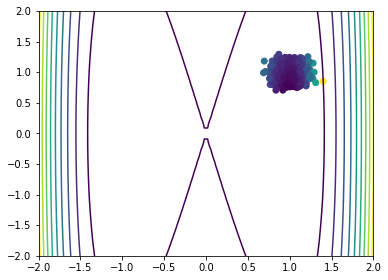

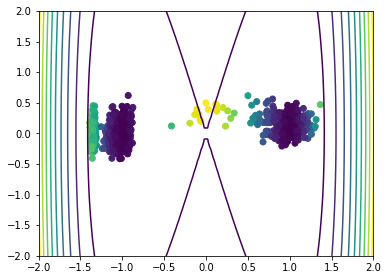

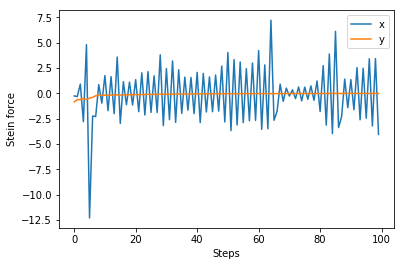

In [23]:
plotSampling_fromData(X0,  methodName=None, color='b', title='Initial state')
plotSampling_fromData(q, methodName=None, color='b', title = 'After '+repr(numberOfSteinSteps)+' Stein CV Langeivn steps',
                     savefigure = folderName+'/stein_langevin_cv.png')

fs = np.asarray(stein_force_save)

plt.plot(range(len(fs)), np.mean(fs, axis=1))
plt.xlabel('Steps')
plt.ylabel('Stein force')
plt.legend(['x','y'])
plt.show()

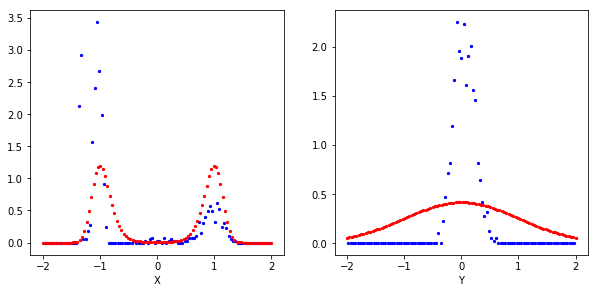

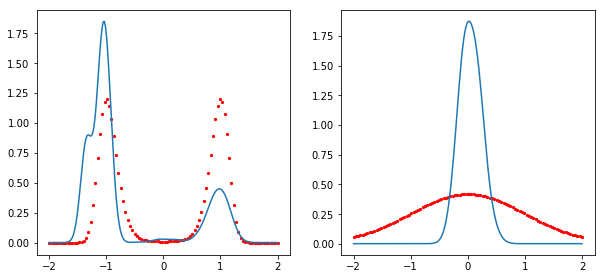

In [24]:
#print(np.asarray(states_evolution_serialLangevin).shape)
plotDistributions(np.asarray(q), figname = folderName+'/stein_langevin_distr.png')

# Invariant Stein
X^{n+1} = X^n + (K(X^n)nabla log(pi) + div K(X^n))dt + sqrt(2K(X)dt)*G

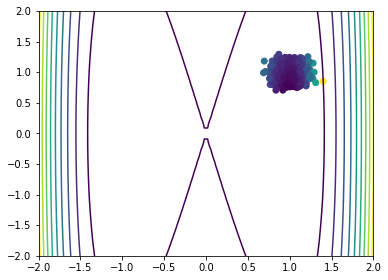

Stein iteration 0


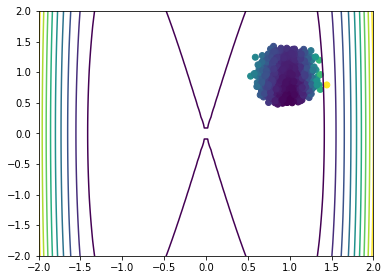

Stein iteration 10


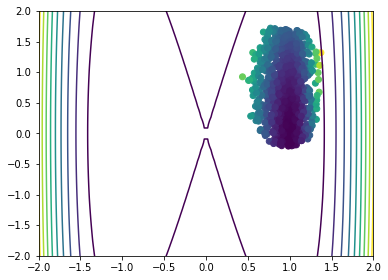

Stein iteration 20


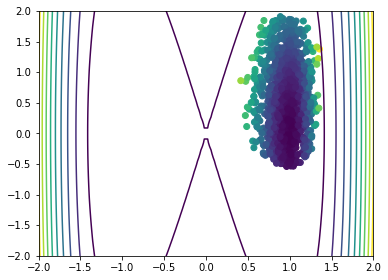

Stein iteration 30


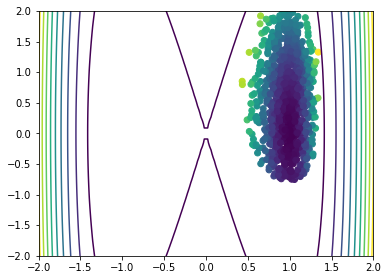

Stein iteration 40


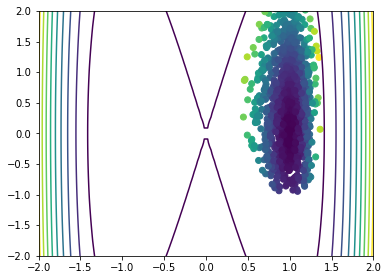

Stein iteration 50


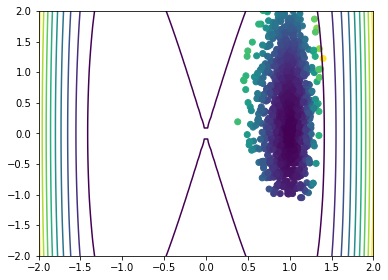

Stein iteration 60


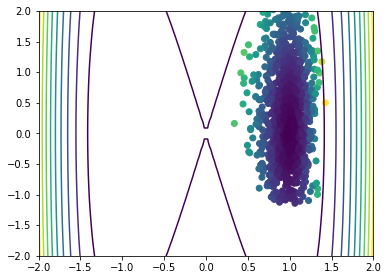

Stein iteration 70


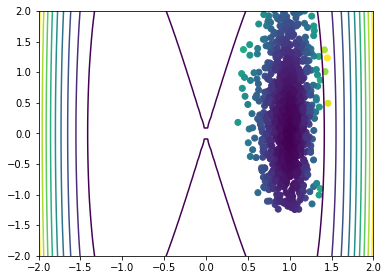

Stein iteration 80


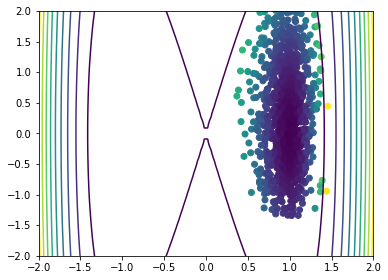

Stein iteration 90


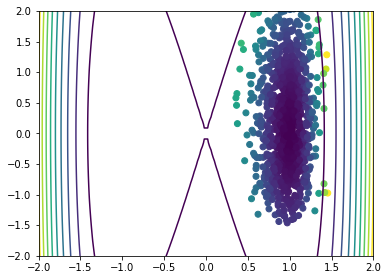

In [25]:
import scipy.linalg as scl

X_short = np.copy(X0)
#q_density=q_density[::10]


mass = 1 

q = np.copy(X_short)

XL=np.copy(q)
plotSampling_fromData(q, methodName=None, color='b', title = 'Initial condition')
f= compute_stein_force(XL,leader_set,bandwidth=BDW)

#f = compute_force(XL)

modit = int(numberOfSteinSteps/10)
moditfig = int(numberOfSteinSteps/10)
KL = np.zeros(numberOfSteinSteps)
Obs_average = np.zeros(numberOfSteinSteps)

states_evolution_invariant_stein =[]


q=[]

for ns in range(numberOfSteinSteps):
    if ns%modit==0:
        print('Stein iteration '+repr(ns))
    f, kernel = compute_stein_force(XL,leader_set,bandwidth=BDW, return_kernel = True)
    
#    K=2.0*kernel/ float(len(XL))
    U, s, V = np.linalg.svd(kernel)

    sqrt2K=np.matmul(U,np.matmul( np.diag(np.sqrt(s)), V))
    #U, s, V = np.linalg.svd(K, full_matrices=True)
    
    #sqrt2K = np.dot(np.dot(U, np.diag(np.sqrt(s))),V)
    
    G = np.random.randn(*XL.shape)
    XL = XL + epsilon_step * f + np.sqrt(2.0*epsilon_step/float(len(XL)))*np.dot(sqrt2K,G)
    
    q =  np.copy(XL)
    #q=np.append(np.copy(q))#,np.asarray(XL))
    Obs_average[ns] = np.mean(q)
    states_evolution_invariant_stein.append(q)
    
    ## plot progress
    if ns%moditfig==0:
        plotSampling_fromData(q, methodName=None, color='b', title = 'Initial condition', savefigure=None)
    if np.isnan(q).any():
        print('Explosion. Nan.')
        break
    

In [26]:
# Invariant Stein with projection on CV

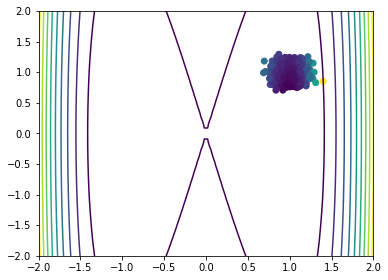

Stein iteration 0


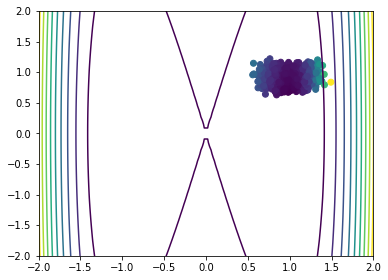

Stein iteration 10


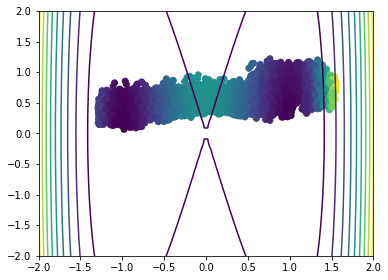

Stein iteration 20


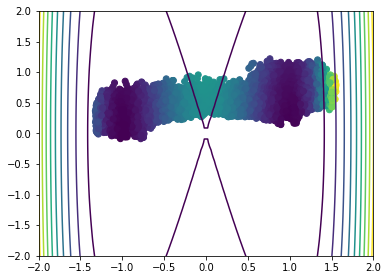

Stein iteration 30


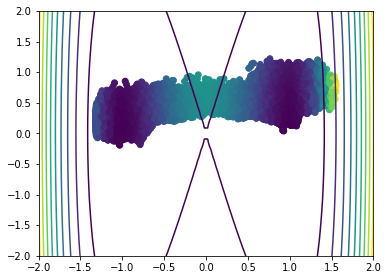

Stein iteration 40


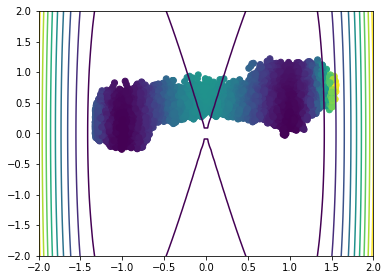

Stein iteration 50


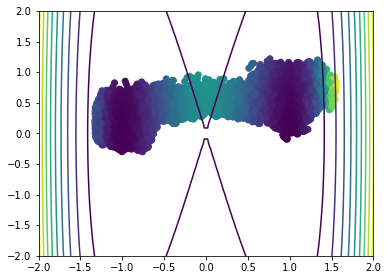

Stein iteration 60


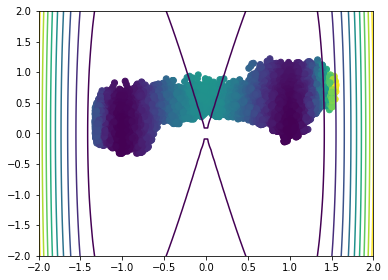

Stein iteration 70


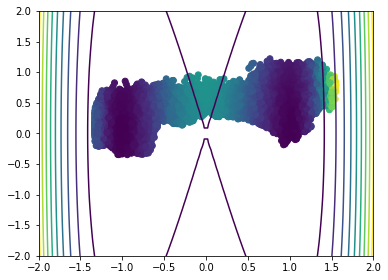

Stein iteration 80


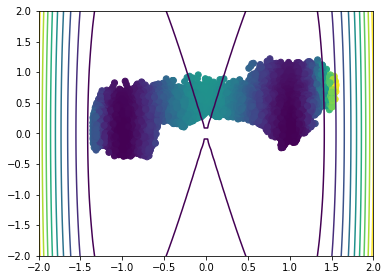

Stein iteration 90


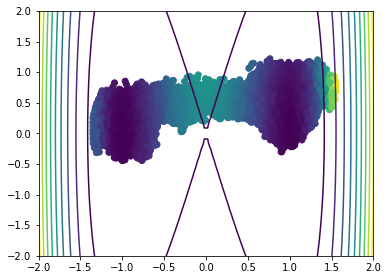

In [27]:
import scipy.linalg as scl



X_short = np.copy(X0)
#q_density=q_density[::10]

BDW = 0.1


mass = 1 

q = np.copy(X_short)

XL=np.copy(q)
plotSampling_fromData(q, methodName=None, color='b', title = 'Initial condition')
f, kernel = compute_stein_force(XL,leader_set, bandwidth=BDW, collective_variable = collective_variable, gradient_collective_variable = gradient_collective_variable,
                       return_kernel = True)

#f = compute_force(XL)

modit = int(numberOfSteinSteps/10)
moditfig = int(numberOfSteinSteps/10)
KL = np.zeros(numberOfSteinSteps)
Obs_average = np.zeros(numberOfSteinSteps)

states_evolution_invariant_stein_cv =[]


q=[]

for ns in range(numberOfSteinSteps):
    if ns%modit==0:
        print('Stein iteration '+repr(ns))
    f, kernel = compute_stein_force(XL,leader_set, bandwidth=BDW, collective_variable = collective_variable, gradient_collective_variable = gradient_collective_variable,
                       return_kernel = True)


    
#    K=2.0*kernel/ float(len(XL))
    U, s, V = np.linalg.svd(kernel)

    sqrt2K=np.matmul(U,np.matmul( np.diag(np.sqrt(s)), V))
    #U, s, V = np.linalg.svd(K, full_matrices=True)
    
    #sqrt2K = np.dot(np.dot(U, np.diag(np.sqrt(s))),V)
    
    G = np.random.randn(*XL.shape)
    XL = XL + epsilon_step * f + np.sqrt(2.0*epsilon_step/float(len(XL)))*np.dot(sqrt2K,G)
    
    q =  np.copy(XL)
    #q=np.append(np.copy(q))#,np.asarray(XL))
    #Obs_average[ns] = np.mean(q)
    states_evolution_invariant_stein_cv.append(q)
    
    ## plot progress
    if ns%moditfig==0:
        all_data =np.asarray(states_evolution_invariant_stein_cv)
        all_data = all_data.reshape(all_data.shape[0]*all_data.shape[1],all_data.shape[2])
        plotSampling_fromData(all_data, methodName=None, color='b', title = 'Initial condition', savefigure=None)
    if np.isnan(q).any():
        print('Explosion. Nan.')
        break
    

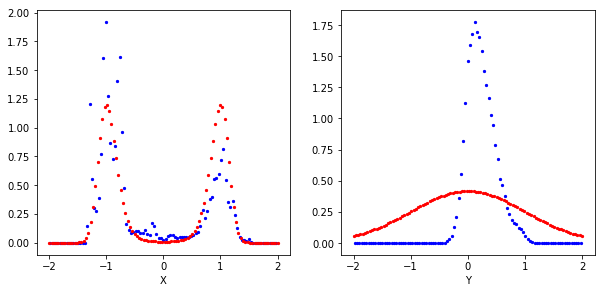

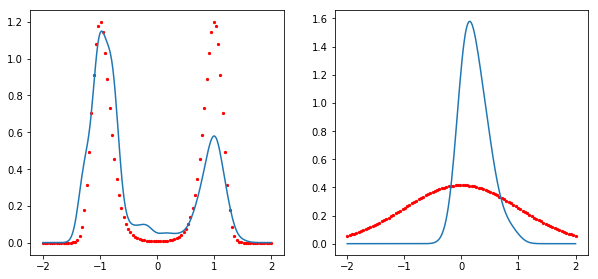

In [28]:
plotDistributions(np.asarray(all_data), figname = folderName+'/inv_stein_cv.png')

# Postprocessing

In [29]:
np.save(folder+'/stein_data.npy',np.asarray(states_evolution_stein))
np.save(folder+'/stein_cv_data.npy',np.asarray(states_CV_evolution_stein))
np.save(folder+'/langevin_data.npy',states_evolution_Langevin)
np.save(folder+'/steinlangevin_data.npy',states_evolution_stein_langevin)
np.save(folder+'/seriallangevin_data.npy',states_evolution_serialLangevin)
np.save(folder+'/invariant_stein_cv.npy',states_evolution_invariant_stein_cv)
 

In [30]:


def meanErr(x,hist_exact):
    return np.mean(np.abs(hist_exact[:-1] - x))/np.mean(np.abs(hist_exact[:-1] ))

def normErr(x,hist_exact):
    return np.linalg.norm(np.abs(hist_exact[:-1] - x))/np.linalg.norm(np.abs(hist_exact[:-1] ))

err_func=normErr


In [41]:

xx = np.linspace(-2,2,100)
yy = np.linspace(-2,2,100)

Zx = sum(np.exp(-energy_DW(xx))) * (xx[1]-xx[0])
Zy = sum(np.exp(-energy_HO(yy))) * (yy[1]-yy[0])

hist_exact_X=np.exp(- energy_DW(xx))/Zx
hist_exact_Y=np.exp(- energy_DW(yy))/Zy

err_stein=np.zeros(numberOfSteinSteps)
err_langevin=np.zeros(numberOfSteinSteps)
err_seriallangevin=np.zeros(numberOfSteinSteps)
err_steinlangevin=np.zeros(numberOfSteinSteps)
err_invstein=np.zeros(numberOfSteinSteps)
err_cv_stein=np.zeros(numberOfSteinSteps)

#print(np.abs(hist_exact[:-1] - data_steinlangevin)/np.abs(hist_exact[:-1] ))
for n in range(numberOfSteinSteps):
    
    q_curr_stein = states_evolution_stein[n]
    q_curr_CV_stein = states_CV_evolution_stein[n]

    q_curr_langevin = states_evolution_Langevin[n]
    
    q_curr_steinlangevin = states_evolution_stein_langevin[n]
   
    
    data_stein, bins = np.histogram(q_curr_stein[:,0], xx, density=True)
    data_cv_stein, bins = np.histogram(q_curr_CV_stein[:,0], xx, density=True)
    data_langevin, bins = np.histogram(q_curr_langevin[:,0], xx, density=True)
   
    data_steinlangevin, bins = np.histogram(q_curr_steinlangevin[:,0], xx, density=True)
    
    err_stein[n] = err_func(data_stein,hist_exact_X )
    err_cv_stein[n] = err_func(data_cv_stein,hist_exact_X )
    
    err_langevin[n] = err_func(data_langevin,hist_exact_X )
    
    err_steinlangevin[n] =  err_func(data_steinlangevin,hist_exact_X )
    
    
    q_curr_invariantstein = np.asarray(states_evolution_invariant_stein_cv)[:n,0]
    q_curr_invariantstein=np.asarray(q_curr_invariantstein)
    
   
    data_invstein, bins = np.histogram(q_curr_invariantstein[:,0], xx, density=True)
    err_invstein[n] = err_func(data_invstein,hist_exact_X )
        
nst=0
mdrnrpart=1 #int(numberOfSerialLangevinSteps/numberOfSteinSteps)
for n in range(1,numberOfSteinSteps):
    
    if n%mdrnrpart ==0:

        #q_curr_seriallangevin = np.asarray(states_evolution_serialLangevin[:n])
        q_curr_seriallangevin = np.asarray(states_evolution_serialLangevin[:n])
        #print(q_curr_seriallangevin.shape)
        data_seriallangevin, bins = np.histogram(q_curr_seriallangevin[:,0], xx, density=True)
        err_seriallangevin[nst] = err_func(data_seriallangevin,hist_exact_X )
        
        
        nst+=1

/Users/zofia/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:817: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bins


(99,)


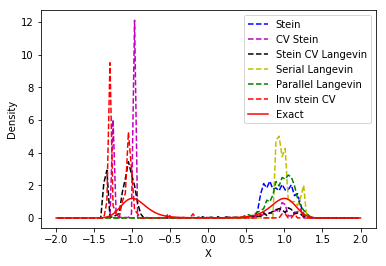

In [42]:
bin_centers = (bins[:-1]+bins[1:])/2
print(bin_centers.shape)
plt.plot(bin_centers, data_stein , '--b')#, s=5)
plt.plot(bin_centers, data_cv_stein , '--m')#, s=5)
plt.plot(bin_centers, data_steinlangevin , '--k')#, s=5)
plt.plot(bin_centers, data_seriallangevin , '--y')#, s=5)
plt.plot(bin_centers, data_langevin , '--g')#, s=5)
plt.plot(bin_centers, data_invstein , '--r')#, s=5)


#plt.plot(bin_centers, data_invstein , '--m')#, s=5)


plt.plot(xx,hist_exact_X ,'-r')
plt.legend(['Stein','CV Stein', 'Stein CV Langevin','Serial Langevin','Parallel Langevin','Inv stein CV','Exact'])
plt.xlabel('X')
plt.ylabel('Density')

plt.savefig(folder+'/hist_all.png',  format='png', dpi=100, bbox_inches='tight')
plt.show()

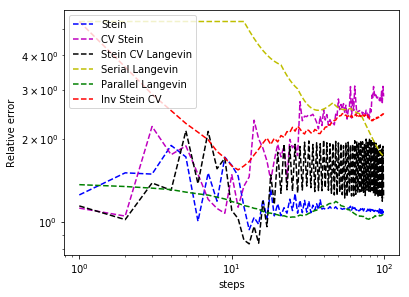

In [43]:

fig = plt.figure(figsize=(6,4.5))
ax = fig.add_subplot(111)

init=0

ax.loglog(range(init,numberOfSteinSteps), err_stein[init:], '--b')
ax.loglog(range(init,numberOfSteinSteps), err_cv_stein[init:], '--m')
ax.loglog(range(init,numberOfSteinSteps), err_steinlangevin[init:], '--k')
ax.loglog(range(init,numberOfSteinSteps), err_seriallangevin[init:],  '--y')
ax.loglog(range(init,numberOfSteinSteps), err_langevin[init:],  '--g')
ax.loglog(range(init,numberOfSteinSteps), err_invstein[init:],  '--r')


#ax.loglog(range(init,numberOfSteinSteps), err_invstein[init:],  '--m')


plt.legend(['Stein','CV Stein', 'Stein CV Langevin','Serial Langevin','Parallel Langevin', 'Inv Stein CV'])
ax.set_xlabel('steps')
ax.set_ylabel('Relative error')
plt.savefig(folder+'/error_all.png',  format='png', dpi=100, bbox_inches='tight')
plt.show()

In [34]:
# import glob
# import moviepy.editor as mpy

# gif_name = 'SteinFigures/h'+repr(h1)+'/gif/Langevin/langevin'
# fps = 1
# file_list = glob.glob('SteinFigures/h'+repr(h1)+'/gif/Langevin/*.png') # Get all the pngs in the current directory
# #list.sort(file_list, key=lambda x: int(x.split('_')[1].split('.png')[0])) # Sort the images by #, this may need to be tweaked for your use case
# clip = mpy.ImageSequenceClip(file_list, fps=fps)
# clip.write_gif('{}.gif'.format(gif_name), fps=fps)

In [35]:
#np.save('SteinFigures/h'+repr(h1)+'/langevin_data.npy',states_evolution_Langevin)
#
#np.save('SteinFigures/h'+repr(h1)+'/stein_combined_with_lagevin_data.npy',states_evolution_stein)

# states_evolution_Langevin = np.load('SteinFigures/h'+repr(h1)+'/langevin_data.npy')
#states_evolution_Langevin = np.load('SteinFigures/h'+repr(h1)+'/stein_combined_with_lagevin_data.npy')
#states_evolution_stein = np.load('SteinFigures/h'+repr(h1)+'/stein_data.npy')